In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
from tqdm import tqdm

import utils

In [2]:
clusters = {
	'canadian_cluster':{
		'regions':{
		'CAN-0': {'stations':['NEW', 'T19', 'C10', 'LET', 'T03', 'T43']},
		'CAN-1': {'stations':['LET', 'T03', 'T43', 'RED', 'C06']},
		'CAN-2': {'stations':['T43', 'RED', 'C06', 'MEA', 'T36']}
		}
	},
	'greenland_cluster':{
		'regions':{
		'GRL-0': {'stations':['GHB', 'SKT', 'STF', 'ATU']},
		'GRL-1': {'stations':['SKT', 'STF', 'ATU', 'GDH']},
		'GRL-2': {'stations':['STF', 'ATU', 'GDH', 'UMQ']},
		'GRL-3': {'stations':['GHB', 'FHB', 'NAQ']},
		}
	},
	'fennoscandinavian_cluster':{
		'regions':{
		'FSC-0': {'stations':['RVK', 'LYC', 'DON', 'JCK']},
		'FSC-1': {'stations':['HAN', 'MEK', 'OUJ', 'NUR']},
		'FSC-2': {'stations':['MAS', 'NOR', 'IVA', 'KEV', 'KIL', 'MUO', 'SOR', 'TRO', 'ABK', 'KIR']},
		'FSC-3': {'stations':['MAS', 'AND', 'KIL', 'MUO', 'SOR', 'TRO', 'ABK', 'KIR']},
		'FSC-4': {'stations':['MAS', 'SOD', 'IVA', 'KEV', 'KIL', 'MUO', 'ABK', 'KIR', 'PEL']},
		'FSC-5': {'stations':['JCK', 'DON', 'ABK', 'KIR', 'LYC']},
		'FSC-6': {'stations':['MAS', 'AND', 'KIL', 'MUO', 'JCK', 'TRO', 'ABK', 'KIR', 'PEL']},
		}
	},
	'central_european_cluster':{
		'regions':{
		'CEU-0': {'stations':['ZAG', 'LVV', 'BEL', 'VYH']},
		'CEU-1': {'stations':['BEL', 'HLP', 'SZC', 'KLD']},
		'CEU-2': {'stations':['THY', 'BDV', 'WIC', 'NCK', 'HRB']},
		'CEU-3': {'stations':['ROE', 'BFE', 'WNG']},
		}
	},
	'non_cluster_regions':{
		'regions':{
		'SVLB': {'stations':['BBG', 'LYR', 'HOR', 'NAL', 'HRN', 'HOP']},
		'JPN-0': {'stations':['KUJ', 'KNY', 'KAG']},
		'JPN-1': {'stations':['MMB', 'ASB', 'RIK', 'MSR']},
		'ALSK': {'stations':['CMO', 'FYU', 'PKR', 'GAK']},
		'HUD-0': {'stations':['PIN', 'ISL', 'C05']},
		'HUD-1': {'stations':['FCC', 'EKP', 'RAN', 'BLC']},
		}
	}
}
forecasts = [1, 5, 10, 15, 20, 25, 30]
windows = [1, 5, 10, 15, 20, 25, 30]


In [3]:
def getting_storm_times(df, lead=24, recovery=48, twins=False, target_var=None, map_keys=None, classification=False):

	'''
	Pulling out storms using a defined list of datetime strings, adding a lead and recovery time to it and
	appending each storm to a list which will be later processed.

	Args:
		data (list of pd.dataframes): ACE and supermag data with the test set's already removed.
		lead (int): how much time in hours to add to the beginning of the storm.
		recovery (int): how much recovery time in hours to add to the end of the storm.
		sw_only (bool): True if this is the solar wind only data, will drop dbht from the feature list.

	Returns:
		list: ace and supermag dataframes for storm times
		list: np.arrays of shape (n,2) containing a one hot encoded boolean target array
	'''

	# setting the datetime index
	if 'Date_UTC' in df.columns:
		pd.to_datetime(df['Date_UTC'], format='%Y-%m-%d %H:%M:%S')
		df.reset_index(drop=True, inplace=True)
		df.set_index('Date_UTC', inplace=True, drop=True)
	else:
		print('Date_UTC not in columns. Check to make sure index is datetime not integer.')

	df.index = pd.to_datetime(df.index)

	# loading the storm list
	if twins and map_keys is None:
		storm_list = pd.read_feather('outputs/regular_twins_map_dates.feather', columns=['dates'])
		storm_list = storm_list['dates']
	elif twins and map_keys is not None:
		storm_list = pd.DataFrame({'dates':[pd.to_datetime(key, format='%Y-%m-%d %H:%M:%S') for key in map_keys]})
		storm_list = storm_list['dates']
	else:
		storm_list = pd.read_csv('stormList.csv', header=None, names=['dates'])
		storm_list = storm_list['Date_UTC']

	stime, etime = [], []					# will store the resulting time stamps here then append them to the storm time df

	# will loop through the storm dates, create a datetime object for the lead and recovery time stamps and append those to different lists
	for date in storm_list:
		if isinstance(date, str):
			date = pd.to_datetime(date, format='%Y-%m-%d %H:%M:%S')
		if twins:
			stime.append(date.round('T')-pd.Timedelta(minutes=lead))
			etime.append(date.round('T')+pd.Timedelta(minutes=recovery))
		else:
			stime.append(date-pd.Timedelta(hours=lead))
			etime.append(date+pd.Timedelta(hours=recovery))

	# adds the time stamp lists to the storm_list dataframes

	storm_list = pd.DataFrame(storm_list, columns=['dates'])
	storm_list['stime'] = stime
	storm_list['etime'] = etime

	storm_list = pd.DataFrame({'stime':stime, 'etime':etime})
	

	return storm_list


def extracting_storm_only_data(df, storm_list):

	storms = pd.DataFrame()

	for start, end in zip(storm_list['stime'], storm_list['etime']):		# looping through the storms to remove the data from the larger df
		if start < df.index[0] or end > df.index[-1]:						# if the storm is outside the range of the data, skip it
			continue
		storm = df[(df.index >= start) & (df.index <= end)]

		if len(storm) != 0:
			storms = pd.concat([storms, storm], axis=0)

	return storms
	 

In [4]:
# for cluster in tqdm(clusters.keys()):
# 	for region in clusters[cluster]['regions'].keys():

cluster = 'greenland_cluster'
region = 'GRL-0'

RP = utils.RegionPreprocessing(cluster,region, features=['dbht'], maximum=True)
region_df = RP()
dates = getting_storm_times(region_df, twins=True)

class_df = pd.DataFrame()
for forecast in forecasts:
	print(f'Forecast length: {forecast}')
	for window in windows:
		
		temp_df = RP.classification_column(df=region_df, param='rsd', forecast=forecast, window=window)

		class_df[f'forecast_{forecast}_window_{window}'] = temp_df['classification']

print('Extracting storm only data...')
storms = extracting_storm_only_data(class_df, dates)

ratio_df = pd.DataFrame(columns=['forecast', 'window', 'percentage'], index=[0])

for forecast in forecasts:
	print(f'Forecast length: {forecast}')
	for window in windows:

		test = storms[f'forecast_{forecast}_window_{window}']

		ratio = test.sum()/len(test)

		ratio_df = pd.concat([ratio_df, pd.DataFrame({'forecast':forecast, 'window':window, 'percentage':ratio}, index=[0])], axis=0)


ratio_df = ratio_df.dropna().reset_index(drop=True, inplace=False)
clusters[cluster]['regions'][region]['ratios'] = ratio_df
	
with open('outputs/cluster_ratios.pkl', 'wb') as f:
	pickle.dump(clusters, f)

{'cluster': 'greenland_cluster', 'region': 'GRL-0', 'features': ['dbht'], 'mean': False, 'std': False, 'maximum': True, 'median': False}
{'cluster': 'greenland_cluster', 'region': 'GRL-0', 'features': ['dbht'], 'mean': False, 'std': False, 'maximum': True, 'median': False, 'forecast': 15, 'window': 15, 'classification': False}
Forecast: 15, Window: 15, Classification: False
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:278: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Date_UTC not in columns. Check to make sure index is datetime not integer.
Forecast length: 1
Forecast length: 5
Forecast length: 10
Forecast length: 15
Forecast length: 20
Forecast length: 25
Forecast length: 30
Extracting storm only data...
Forecast length: 1
Forecast length: 5
Forecast length: 10
Forecast length: 15
Forecast length: 20
Forecast length: 25
Forecast length: 30


/tmp/ipykernel_1640622/3082270972.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ratio_df = pd.concat([ratio_df, pd.DataFrame({'forecast':forecast, 'window':window, 'percentage':ratio}, index=[0])], axis=0)


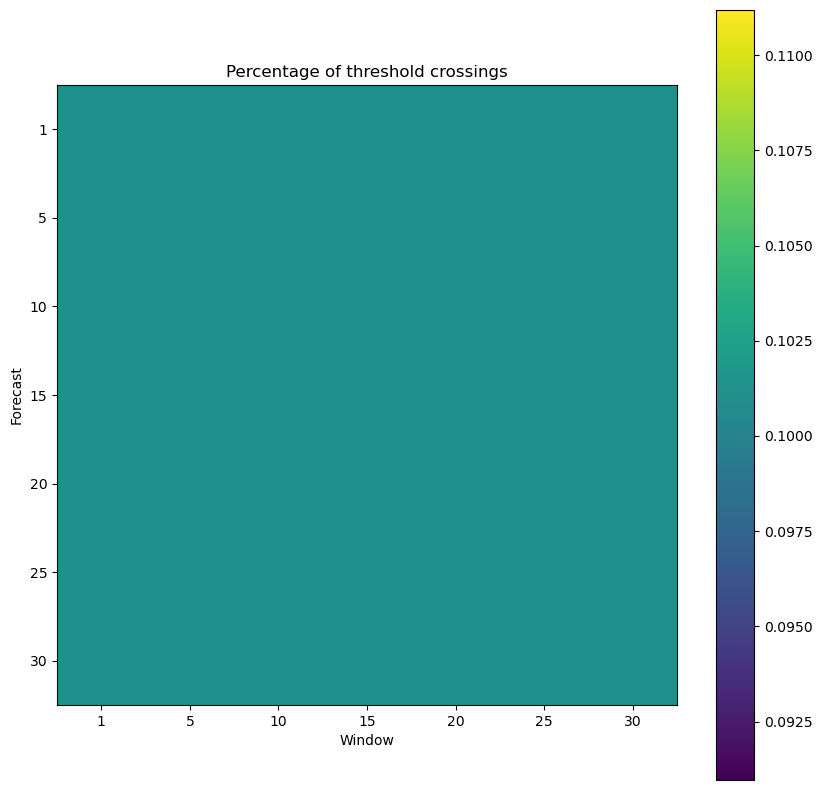

In [5]:
# turning teh ratio df into a pivot table
pivot = ratio_df.pivot_table(index='forecast', columns='window', values='percentage')

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
axes.set_title('Percentage of threshold crossings')
im = axes.imshow(pivot, cmap='viridis')
fig.colorbar(im)
axes.set_xticks(np.arange(len(windows)))
axes.set_xticklabels(windows)
axes.set_xlabel('Window')
axes.set_yticks(np.arange(len(forecasts)))
axes.set_yticklabels(forecasts)
axes.set_ylabel('Forecast')
plt.show()

In [6]:
zero_epoch_times = region_df[region_df['rsd'] >= region_df['rsd'].quantile(0.99)].index
print(zero_epoch_times[-5:])
print(f'Number of zero epoch times before: {len(zero_epoch_times)}')
time_delta = pd.Timedelta(hours=1)
to_drop = []

# declustering the data. If times occur within one hour of each other, only using the time coresponding to the highest value
for i, time in enumerate(zero_epoch_times):
	if i == len(zero_epoch_times)-1:
		break
	while zero_epoch_times[i+1] - time < time_delta:
		print(f'Time: {time}, Next time: {zero_epoch_times[i+1]}')
		# comparing the rsd values at the two times
		if region_df.loc[time, 'rsd'] > region_df.loc[zero_epoch_times[i+1], 'rsd']:
			to_drop.append(zero_epoch_times[i+1])
		else:
			to_drop.append(time)
		i += 1
		if i == len(zero_epoch_times)-1:
			break
	if i == len(zero_epoch_times)-1:
		break
	print(f'This one broke it! Time: {time}, Next time: {zero_epoch_times[i+1]}')

zero_epoch_times = zero_epoch_times.drop(to_drop)
print(f'Number of zero epoch times after: {len(zero_epoch_times)}')
print(zero_epoch_times[-5:])


DatetimeIndex(['2017-12-29 03:04:00', '2017-12-29 03:30:00',
               '2017-12-29 03:32:00', '2017-12-29 03:33:00',
               '2017-12-30 04:02:00'],
              dtype='datetime64[ns]', freq=None)
Number of zero epoch times before: 43682
Time: 2009-07-22 00:30:00, Next time: 2009-07-22 00:31:00
Time: 2009-07-22 00:30:00, Next time: 2009-07-22 00:32:00
This one broke it! Time: 2009-07-22 00:30:00, Next time: 2009-07-22 03:24:00
Time: 2009-07-22 00:31:00, Next time: 2009-07-22 00:32:00
This one broke it! Time: 2009-07-22 00:31:00, Next time: 2009-07-22 03:24:00
This one broke it! Time: 2009-07-22 00:32:00, Next time: 2009-07-22 03:24:00
Time: 2009-07-22 03:24:00, Next time: 2009-07-22 03:32:00
Time: 2009-07-22 03:24:00, Next time: 2009-07-22 03:41:00
Time: 2009-07-22 03:24:00, Next time: 2009-07-22 03:47:00
Time: 2009-07-22 03:24:00, Next time: 2009-07-22 04:00:00
Time: 2009-07-22 03:24:00, Next time: 2009-07-22 04:02:00
Time: 2009-07-22 03:24:00, Next time: 2009-07-22 04:17

In [ ]:
sea_df = pd.DataFrame()
stime, etime = [], []
for date in zero_epoch_times:
	stime.append(date-pd.Timedelta(hours=1))
	etime.append(date+pd.Timedelta(hours=2))
	# sea_df = pd.concat([sea_df, region_df[(region_df.index >= date-pd.Timedelta(hours=12)) & (region_df.index <= date+pd.Timedelta(hours=24))]['rsd']], axis=1)
times = pd.DataFrame({'stime':stime, 'etime':etime})
region = region_df.copy()
for start, end, date in tqdm(zip(stime, etime, zero_epoch_times)):
	sea_df[date] = region[start:end]['rsd'].reset_index(drop=True, inplace=False)


0it [00:00, ?it/s]/tmp/ipykernel_1467001/2857815175.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sea_df[date] = region[start:end]['rsd'].reset_index(drop=True, inplace=False)
5587it [00:02, 2428.60it/s]


In [ ]:
median = sea_df.median(axis=1)
perc_25 = sea_df.quantile(0.25, axis=1)
perc_75 = sea_df.quantile(0.75, axis=1)
perc_90 = sea_df.quantile(0.9, axis=1)
perc_95 = sea_df.quantile(0.95, axis=1)
perc_99 = sea_df.quantile(0.99, axis=1)

sea_df['median'] = median
sea_df['perc_25'] = perc_25
sea_df['perc_75'] = perc_75
sea_df['perc_90'] = perc_90
sea_df['perc_95'] = perc_95
sea_df['perc_99'] = perc_99


/tmp/ipykernel_1467001/394445780.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sea_df['median'] = median
/tmp/ipykernel_1467001/394445780.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sea_df['perc_25'] = perc_25
/tmp/ipykernel_1467001/394445780.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.c

In [ ]:
sea_df.head()

2009-07-22 00:32:00  2009-07-22 04:47:00  2009-07-22 07:02:00  \
0             1.387511            39.202385           105.895493   
1             1.415817            11.912107             8.535454   
2            11.482347            22.897808             2.765057   
3             0.398144            27.408970             3.238520   
4             5.902316            23.329567             3.980129   

   2009-07-22 08:02:00  2009-07-22 10:17:00  2009-07-23 11:14:00  \
0           149.022858            50.430504            10.954363   
1            11.190629            14.083046             3.120021   
2            10.836229            43.386089             2.118997   
3             6.855171            14.117783             1.819777   
4             1.118029            20.672421             4.758637   

   2009-07-23 13:22:00  2009-07-24 01:30:00  2009-07-24 15:51:00  \
0             4.580073             0.338015             0.597186   
1             4.527197             1.148775             1.924863   
2             9.047771             0.759994             4.463883   
3             6.452516             1.268739             2.541322   
4             6.241064             2.416005             7.528439   

   2009-07-25 02:59:00  ...  2017-12-27 04:29:00  2017-12-28 21:16:00  \
0            11.611296  ...             2.402208             1.815918   
1            13.713269  ...             1.277531             0.706220   
2             4.355001  ...             2.608009             1.825538   
3            10.778891  ...             3.113058             0.538337   
4             3.377895  ...             2.176608             0.597195   

   2017-12-29 03:32:00  2017-12-30 04:02:00    median   perc_25   perc_75  \
0             1.282259             8.004433  3.975574  1.662382  9.107766   
1             1.480012             9.167034  3.912386  1.643409  9.002952   
2             3.115707             7.100156  4.097480  1.681679  9.164135   
3             7.552621            11.410624  4.074935  1.688838  8.964525   
4             1.589060             0.811847  3.937001  1.658581  8.881954   

     perc_90    perc_95    perc_99  
0  17.429749  25.673399  50.574978  
1  17.771379  24.816198  44.712029  
2  17.599354  25.412270  44.448952  
3  17.023592  24.475269  45.181652  
4  17.033365  24.352264  45.874157  

[5 rows x 5593 columns]

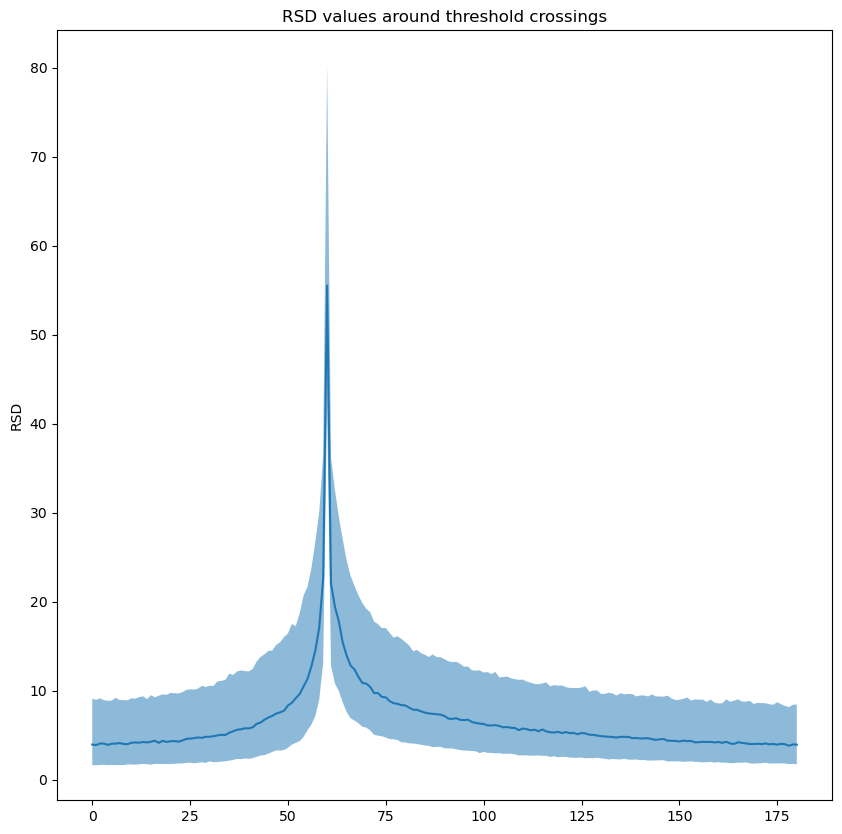

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
axes.plot(sea_df['median'], label='median')
axes.fill_between(sea_df.index, sea_df['perc_25'], sea_df['perc_75'], alpha=0.5, label='25th-75th')
axes.yaxis.set_label_text('RSD')
axes.set_title('RSD values around threshold crossings')
plt.show()

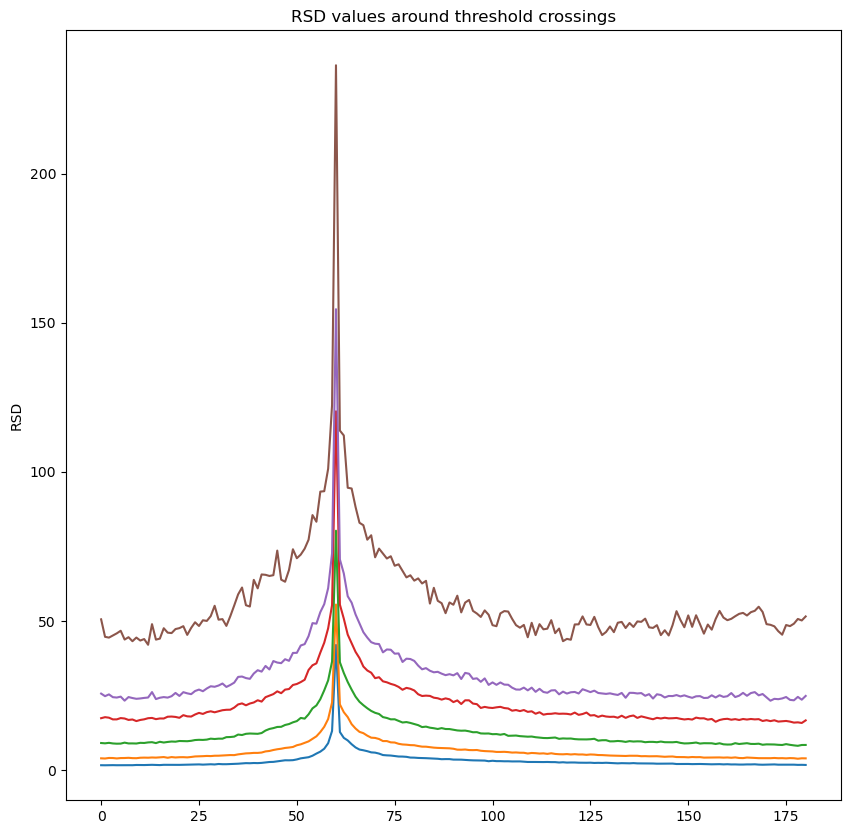

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
axes.plot(sea_df['perc_25'], label='median')
axes.plot(sea_df['median'], label='median')
axes.plot(sea_df['perc_75'], label='25th percentile')
axes.plot(sea_df['perc_90'], label='90th percentile')
axes.plot(sea_df['perc_95'], label='95th percentile')
axes.plot(sea_df['perc_99'], label='99th percentile')
axes.set_title('RSD values around threshold crossings')
axes.yaxis.set_label_text('RSD')
plt.show()

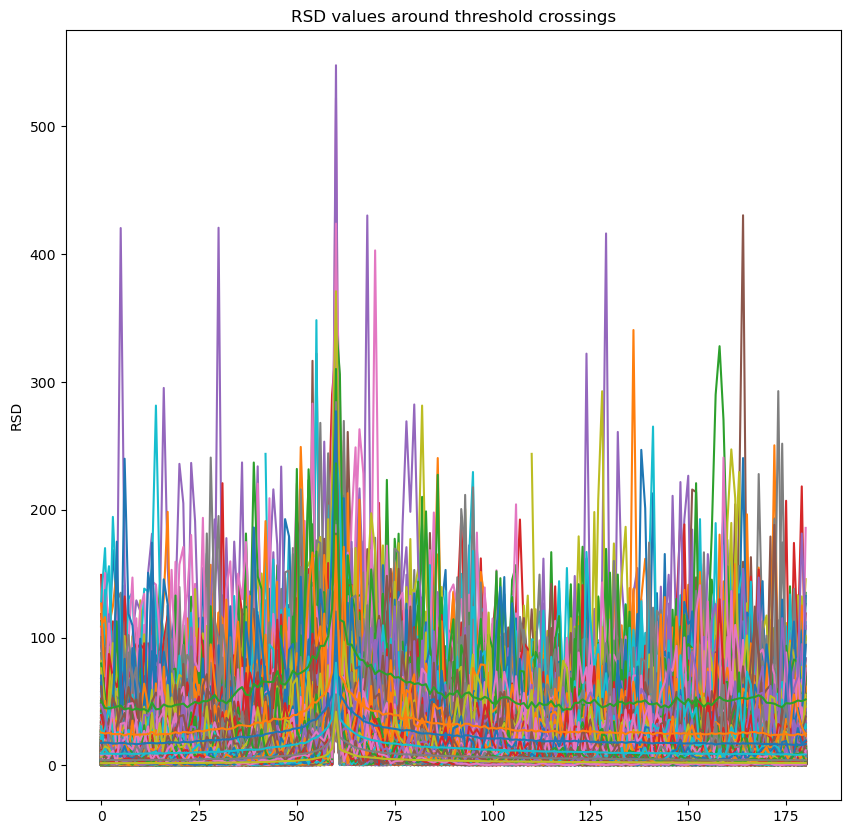

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
for date in sea_df.columns:
	axes.plot(sea_df[date], label=date)
axes.set_title('RSD values around threshold crossings')
axes.yaxis.set_label_text('RSD')
plt.show()

# look at the first spike in RSD for the clusters of RSD as possible zero epoch 